$$
\renewcommand{PDut}{\frac{\partial u}{\partial t}}
\renewcommand{PDuS}{\frac{\partial u}{\partial S}}
\renewcommand{PDuSS}{\frac{\partial ^2u}{\partial S^2}}
\renewcommand{eps}{\varepsilon}
$$
$\newcommand{\a}{\alpha} \newcommand{\s}{\sigma} \newcommand{\half}{\frac{1}{2}} \newcommand{\F}{\mathcal{F}} \newcommand{\P}{\mathbb{P}} \newcommand{\par}{\partial} \newcommand{\R}{\mathbb{R}} \newcommand{\argmin}{\arg\!\min} \newcommand{\E}{\mathbb E} \newcommand{\lb}{\left [} \newcommand{\rb}{\right ]} \newcommand{\U}{\mathcal{U}}$


In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import sys
sys.path.insert(0, '/Users/finn/Desktop/Capstone-BSDE/files')

In [2]:
import numpy as np

from bsde.config.FBSDE import config_option
from bsde.config.simulation import config_simulation
from bsde.config.LSMC import config_linear, config_svm, config_NN

import bsde.dynamics.american_option as us
from bsde.LSMC.LSMC import LSMC_linear
from bsde.LSMC.LSMC_engine import LSMC_engine

The usual PDE (variational inequality) representation of American option price is given by the variational inequality

$$  
    \max \left(\par_t u + \mathcal{L}u - ru, g(x) - u \right) = 0, \quad u(T, x) = g(x) 
$$

which will be used as as the benchmark method for American option pricing. Now, we introduce several nonlinear PDE representation of America option in [Nonlinear Option Pricing](https://www.routledge.com/Nonlinear-Option-Pricing/Guyon-Henry-Labordere/p/book/9781466570337) and [this paper](https://www.ceremade.dauphine.fr/%7Ebouchard/pdf/LPBBSDE-final.pdf).


$$
    \par_t u + \mathcal{L}u + (-ru + (\mathcal{L}g - rg)^-\mathbb{1}_{\{u(t,x) \leq g(x)\}}) = 0, \quad u(T, x) = g(x)
$$
$$
    \par_t u + \mathcal{L}u + (e^{-rt}(rg - \mathcal{L}g) \mathbb{1}_{\{e^{rt}u(t,x) \leq g(x)\}}) = 0, \quad u(T, x) = e^{-rT}g(x)
$$

For put option payoff is given by

$$
    g(x) = (k-x)^+ = 
            \begin{cases}
               k-x &\quad \text{for } x \leq k  \\
               0 &\quad\text{otherwise.} \\ 
             \end{cases}
$$

which is not differentiable at $x = k$. Hence, we will consider the approximation

$$
    g_\eps(x) = 
        \begin{cases}
           k-x &\quad \text{for } x < k - \eps  \\
           \frac{-(x - (k+\eps))^2}{-4\eps} &\quad \text{for } k-\eps \leq x \leq k+\eps \\
           0 &\quad\text{for}  x \geq k + \eps \\ 
         \end{cases}
$$

To visualize our payoff function,

In [3]:
def g(x, K):
    return np.maximum(K - x, 0)

def g_eps(x, K, eps):
    a = K - eps
    b = K + eps
    val1 = np.where(x < a, K-x, 0)
    val2 = np.where((x <= b) & (a <= x), -((x-b)**2)/(-4*eps), 0)
    val3 = np.where(x >= b, 0, 0)
    
    return val1 + val2 + val3

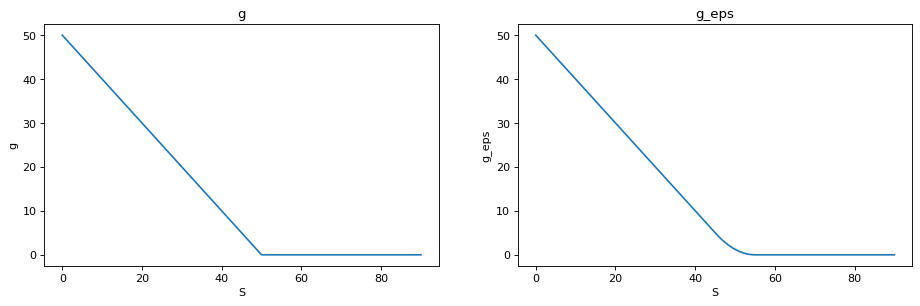

In [4]:
K = 50
xs = np.linspace(0, 90, 1000)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), dpi=80)
ax1.set_title('g')
ax2.set_title('g_eps')

ax1.plot(xs, g(xs, K=K))
ax2.plot(xs, g_eps(xs, K=K, eps=0.1*K))

ax1.set_xlabel("S")
ax2.set_xlabel("S")
ax1.set_ylabel("g")
ax2.set_ylabel("g_eps")
plt.show()

In [5]:
# Market Parameters
r = 0.06
sigs = [0.1, 0.5, 0.8]
s0 = np.array([40])
T = 1
K = 40

# Simulation parameters
Ms = [int(2 ** i) for i in range(4, 19)]
dt = (1 / 252.)
N = int(T / dt)
d = 1
d1 = 1
d2 = 1

In [6]:
# configs
configs_options = [config_option(r=r, sig=sig, K=K, T=T, d=d, d1=d1, d2=d2) for sig in sigs]
configs_sim = [config_simulation(N=N, M=M, dt=dt, seed=42, x0=s0) for M in Ms]

config_model_OLS = config_linear(model_params={}, reg_method=None)
config_model_ridge = config_linear(model_params={'fit_intercept':False}, reg_method='ridge')

# dynamics
FBSDEs = [us.BS_american_FBSDE(cfg) for cfg in configs_options]

In [7]:
# Run the engine - LSMC
engine_OLS = LSMC_engine(FBSDEs, configs_sim, config_model_OLS, LSMC_linear)
engine_OLS.run()

engine_ridge = LSMC_engine(FBSDEs, configs_sim, config_model_ridge, LSMC_linear)
engine_ridge.run()

In [8]:
# PDE

PDE_res = []
S_min = 0.0
S_max = 200

nt = 5000
ns = 399
S_s = np.linspace(S_min, S_max, ns+2)
t_s = np.linspace(0, T, nt+1)

final_payoff = np.maximum(K - S_s, 0)
B_upper = 0*t_s
B_lower = np.exp(-r*t_s) * K

for s in sigs:
    BS_PDE_solver = us.BS_FDM_implicit(r, s, T, S_min, S_max, B_lower, B_upper,
                                                        final_payoff[1:-1], nt, ns)
    u_implicit = BS_PDE_solver.solve()
    n_row = len(u_implicit[:, 1])

    u = u_implicit[n_row-1, :]
    s0_idx = int(2*s0[0]-1)
    
    PDE_res.append(u[s0_idx])

/Users/finn/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [9]:
def plot_american_option_result(all_res, sigs, Ms):
    f, axes = plt.subplots(1, len(sigs), figsize=(15, 4), dpi=80, sharex=True)
    for (i, sig) in enumerate(sigs):
        
        # BSDE and Monte-Carlo
        for res in all_res:
            axes[i].plot(np.log2(Ms), res[0, i, :])
            
        # PDE
        axes[i].axhline(PDE_res[i], linestyle='-.')
        
        # set labels, title, etc.
        axes[i].legend(['LSMC-OLS', 'LSMC-ridge', 'PDE'])
        axes[i].set_title('sigma={}'.format(sig))
        axes[i].set_xlabel('Number of Path - log scale')
        axes[i].set_ylabel('Price')
    
    plt.tight_layout()
    plt.savefig('American_option_update.png', dpi=300, bbox_inches = "tight")
    plt.show()

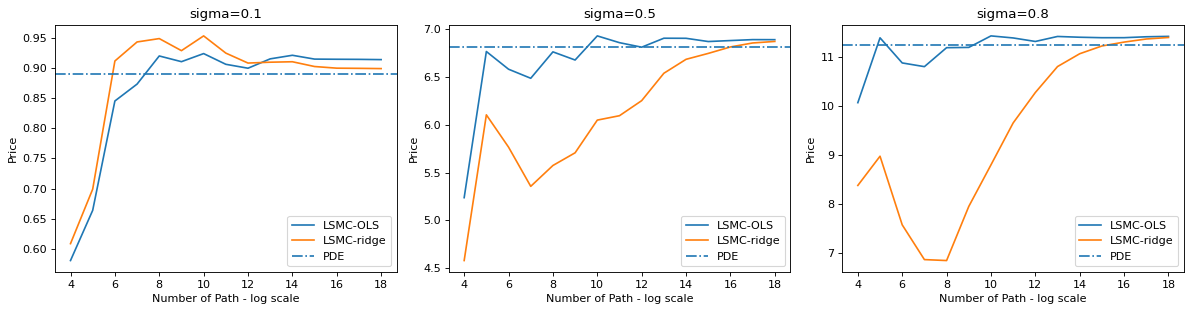

In [10]:
all_res = [engine_OLS.res, engine_ridge.res]
plot_american_option_result(all_res, sigs, Ms)